In [1]:
import uproot
import pandas as pd
import sys,os, time, glob, re  
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.auto import tqdm       
tqdm.pandas()

# import the custom python module
import muonfixedid, chamberlist_run3   
import splitter_regions_Run2
import mdtCalib_functions

import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


inputCalibNtuple='data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0120.ntuple.root'
f=uproot.open(inputCalibNtuple)  


In [2]:
tree=f['Segments']                                     
run = inputCalibNtuple.split('0',1)[1][:6]        
region = int(inputCalibNtuple.split("-", 1)[1][:4])
lb = inputCalibNtuple.split("-", 1)[0][-9:]          
branchList=tree.keys()                                  
branchPrefix=['trk', 'trkHit', 'event', 'rawMdt']       
branchMapping={key : [] for key in branchPrefix}          # branchMapping is a dictionary

for branch in branchList:
    branchName, variableName= branch.split('_', 1)
    if branchName in branchPrefix:
        branchMapping[branchName].append(branch)
# convert mdtCalname to mdtHardname by chamberlist.py
chamberInRegion = [chamberlist_run3.MDThardname(chamberlist_run3.MDTindex(x)) for x in splitter_regions_Run2.regionlist[region]] #???
print('process run %s lumiblock %s region %s, chamberList %s' % (run, lb, region, chamberInRegion))

process run 045672 lumiblock 0000_0004 region 120, chamberList ['IsWRONG', 'BIS7A16', 'EES1A16', 'EES2A16', 'EMS4A16', 'EMS5A16']


In [3]:
import awkward as ak
df_raw=ak.to_dataframe(tree.arrays(branchMapping['rawMdt']))
# df_trk=ak.to_dataframe(tree.arrays(branchMapping['trkHit']))
# df_raw.head(5)
# df_trk.head(5)

# expand all raw and trk hits with correct chamberName and tubeInfo
df_raw['rawMdt_tubeInfo'] = df_raw['rawMdt_id'].apply(lambda x : chamberlist_run3.MDTtubename(int(x)))
df_raw['rawMdt_station'] = df_raw['rawMdt_tubeInfo'].apply(lambda x :x[:7])
df_raw['rawMdt_type'] = df_raw['rawMdt_tubeInfo'].apply(lambda x :x[:3])
print(df_raw.head(5))

# df_trk['trkHit_tubeInfo']=df_trk['trkHit_id'].apply(lambda x: chamberlist_run3.MDTtubename(int(x)))
# df_trk['trkHit_station']=df_trk['trkHit_tubeInfo'].apply(lambda x:x[:7])
# df_trk['trkHit_type']=df_trk['trkHit_tubeInfo'].apply(lambda x:x[:3])
# print(df_trk.head(5))

# Extract raw and trk info for chamber 'BIS7A16'

# for hitType in df_raw['rawMdt_station']:
#     if hitType=='BIS7A16':
#         print(hitType)
    
# df_raw_BIS = df_raw[df_raw['rawMdt_type'] == 'BIS']                     #not required
# df_BIS

# df_raw_chamber = df_raw[df_raw['rawMdt_station'] == 'BIS7A16']
# print(df_raw_chamber.head(5))                                              #all rawMdt values for BIS7A16

# df_trk_chamber=df_trk[df_trk['trkHit_station']=='BIS7A16']
# print(df_trk_chamber.head(5))                                            ##all trk values for BIS7A16


                rawMdt_adc  rawMdt_gPosX  rawMdt_gPosY  rawMdt_gPosZ  \
entry subentry                                                         
0     0                 99   4114.294922  -1704.196777   9544.875000   
      1                111   4114.294922  -1704.196777   9454.769531   
      2                148   4114.294922  -1704.196777   9424.735352   
      3                198   4114.294922  -1704.196777   9094.349609   
      4                 92   4090.263916  -1694.242798   9469.787109   

                rawMdt_id  rawMdt_nRMdt  rawMdt_tdc rawMdt_tubeInfo  \
entry subentry                                                        
0     0         105446809            45        1055  BEE1A16-1-4-26   
      1         105446806            45        1172  BEE1A16-1-4-23   
      2         105446805            45         489  BEE1A16-1-4-22   
      3         105446794            45         724  BEE1A16-1-4-11   
      4         105446678            45        1207  BEE1A16-1-3-23  

In [3]:
# df_all = tree.arrays()
# print(f'Total Event in this file is {len(df_all)}')

In [24]:
df_raw_chamber=df_raw[df_raw['rawMdt_station']=='BIS7A16']
df_raw_chamber

rawMdt_adc  rawMdt_gPosX  rawMdt_gPosY  rawMdt_gPosZ  \
entry subentry                                                         
1     0                242   4313.193848  -1786.583252   7326.850098   
      1                 36   4313.193848  -1786.583252   7206.049805   
      2                162   4313.193848  -1786.583252   7175.850098   
      3                138   4313.193848  -1786.583252   7175.850098   
      4                 64   4313.193848  -1786.583252   7160.750000   
...                    ...           ...           ...           ...   
33004 16               164   4222.755859  -1749.122803   6050.899902   
      17               174   4210.663086  -1744.113892   6375.549805   
      18                35   4198.570801  -1739.104858   6685.100098   
33005 13                36   4313.193848  -1786.583252   6647.350098   
      14               146   4222.755859  -1749.122803   6186.799805   

                rawMdt_id  rawMdt_nRMdt  rawMdt_tdc rawMdt_tubeInfo  \
entry subentry                                                        
1     0          24707037           101         712  BIS7A16-2-4-94   
      1          24707029           101         151  BIS7A16-2-4-86   
      2          24707027           101         129  BIS7A16-2-4-84   
      3          24707027           101        1271  BIS7A16-2-4-84   
      4          24707026           101         976  BIS7A16-2-4-83   
...                   ...           ...         ...             ...   
33004 16         24706313           117         183  BIS7A16-1-3-10   
      17         24706206           117         341  BIS7A16-1-2-31   
      18         24706099           117        1441  BIS7A16-1-1-52   
33005 13         24706992           146        1347  BIS7A16-2-4-49   
      14         24706322           146         298  BIS7A16-1-3-19   

               rawMdt_station rawMdt_type  
entry subentry                             
1     0               BIS7A16         BIS  
      1               BIS7A16         BIS  
      2               BIS7A16         BIS  
      3               BIS7A16         BIS  
      4               BIS7A16         BIS  
...                       ...         ...  
33004 16              BIS7A16         BIS  
      17              BIS7A16         BIS  
      18              BIS7A16         BIS  
33005 13              BIS7A16         BIS  
      14              BIS7A16         BIS  

[278453 rows x 10 columns]

# Tube_index and noise_rate dataframe

In [79]:
def tube(df, chamber):
    df_raw_chamber = df[df['rawMdt_station']==chamber]
   
    chamberinfo = list(df_raw_chamber.rawMdt_tubeInfo)
    tube_index=[]
    ch=[]
    tube_chamber_mapping={}
    for x in chamberinfo:
        ml_index=int(x.split('-')[1])
        ly_index =int(x.split('-')[2])
        # nLayer = (int(x.split('-')[1])-1)*4 + int(x.split('-')[2])
        tube_id =int(x.split('-')[3])
        tube_index_ml=(ml_index-1)*chamberlist_run3.MDTnTml(chamber,1) + (ly_index-1)*chamberlist_run3.MDTnTly(chamber,ml_index) + tube_id
        
        tube_index.append(tube_index_ml)  
        ch.append(x)
    data_dict=dict(zip(ch,tube_index))
    return data_dict    #keys:tubeinfo, value:tube_index
    
#Noise rate
def noise_rate(df, chamber):
    df_raw_chamber = df[df['rawMdt_station']==chamber]
    
    tube_hits=df_raw_chamber.rawMdt_tubeInfo.value_counts()

    print("tube hit type",tube_hits.iloc[0])

    act_time_window=1.3*(10**(-6))
    total_evts=33007
    noise_rate=tube_hits/(act_time_window*total_evts)
    return noise_rate
    
def extracted_df_for_noise_rate(df,chamber):
    noise_ = noise_rate(df,chamber)
    idxs = noise_.index

    tube_dict = tube(df,chamber)

    tube_noise_dict = {"Tube ID": [], "Noise Rate": [], "Tube Name": []}

    hit_freq_dict = {}
    for i in idxs:
        tube_idx = tube_dict[i]
        hit_freq = noise_[i]
        hit_freq_dict[tube_idx] = hit_freq

    df_new=pd.DataFrame(hit_freq_dict.values(),index=hit_freq_dict.keys(),columns=['Noise_rate'])
    df_new=df_new.reset_index()
    return df_new
extracted_df_for_noise_rate(df_raw_chamber,'BIS7A16')

tube hit type 21178


,index,Noise_rate
0,601,493554.980179
1,568,299167.309498
2,567,246987.235808
3,636,238713.932476
4,635,202427.923214
...,...,...
642,452,1281.779389
643,276,186.440638
644,275,116.525399
645,553,93.220319


In [133]:
def tube_id(row, chamber):
    # Grab the tube name
    x = row[0]
    # Split into components that were separated by a '-'
    ml_index=int(x.split('-')[1])
    ly_index =int(x.split('-')[2])
    tube_no =int(x.split('-')[3])

    # Calculate unique tube id 
    return (ml_index-1)*chamberlist_run3.MDTnTml(chamber,1) + (ly_index-1)*chamberlist_run3.MDTnTly(chamber,ml_index) + tube_no

act_time_window=1.3*(10**(-6))
total_evts=33007    

#Noise rate
def noise_rate(df, chamber):
    df_raw_chamber = df[df['rawMdt_station']==chamber]

    # Aggregate tube hits with pandas value_counts() method
    tube_hits=df_raw_chamber.rawMdt_tubeInfo.value_counts()

    # Recalculate all noise_rates and construct them into a new Series
    noise_rate=tube_hits/(act_time_window*total_evts)
    # Convert to dataframe
    noise_rate_df = noise_rate.reset_index()
    # Add column names to two columns
    noise_rate_df.columns = ['Tube_Name', 'Noise_Rate']
    # Create new column for tube ids and calculate each id inline in the tube_id() function
    noise_rate_df['Tube_ID'] = noise_rate_df.apply(lambda row: tube_id(row, chamber), axis=1)
    
    return noise_rate_df #returns a dataframe
data=noise_rate(df_raw_chamber,'BIS7A16')
data

/var/folders/w3/c0s4x6mj0rd2h643_w1y144r0000gn/T/ipykernel_94273/306651360.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = row[0]


,Tube Name,Noise Rate,Tube_ID
0,BIS7A16-2-4-49,493554.980179,601
1,BIS7A16-2-4-16,299167.309498,568
2,BIS7A16-2-4-15,246987.235808,567
3,BIS7A16-2-4-84,238713.932476,636
4,BIS7A16-2-4-83,202427.923214,635
...,...,...,...
642,BIS7A16-2-2-92,1281.779389,452
643,BIS7A16-2-1-12,186.440638,276
644,BIS7A16-2-1-11,116.525399,275
645,BIS7A16-2-4-1,93.220319,553


# Plots

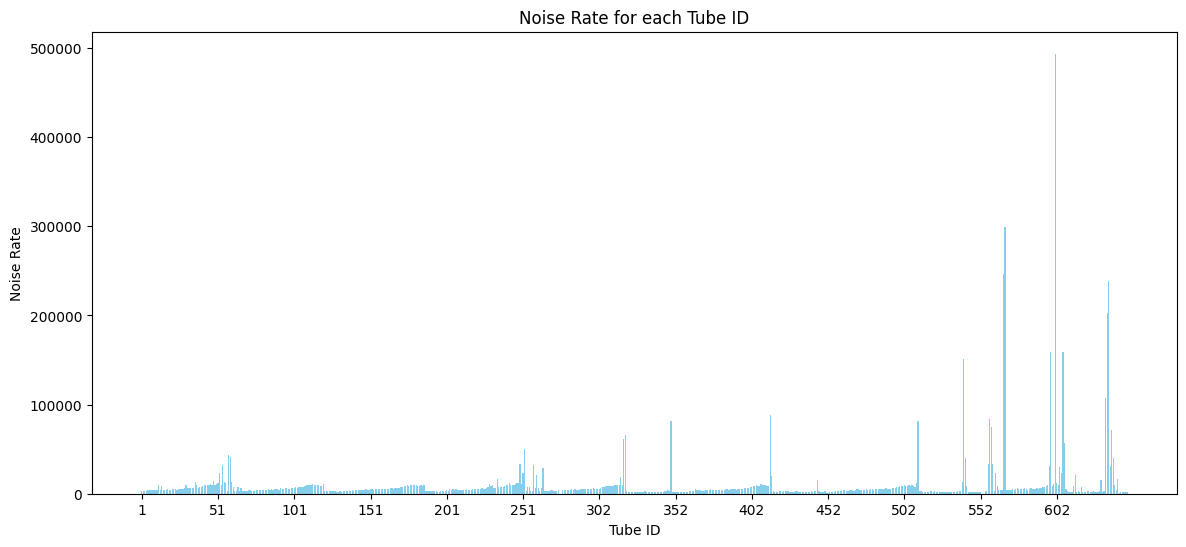

In [45]:
#Bar Plot
def plot_for_noise_rate(df):
    
# Ensure that 'tube_id' is sorted if there is a specific order you wish to maintain
    df_sorted = df.sort_values(by='index', ascending=True)

    plt.figure(figsize=(14, 6))  # Set the figure size
    alpha_value = 1  # Transparency
    
    plt.bar(df_sorted['index'].astype(str), df_sorted['Noise_rate'], color='skyblue')
    
    plt.title('Noise Rate for each Tube ID')
    plt.xlabel('Tube ID')
    plt.ylabel('Noise Rate')
    plt.xticks(np.arange(0, len(df_sorted['index'])+1, 50))
    # plt.xticks(rotation=90)

    plt.show()
plot_for_noise_rate(df_new)

# Introducing adc cut

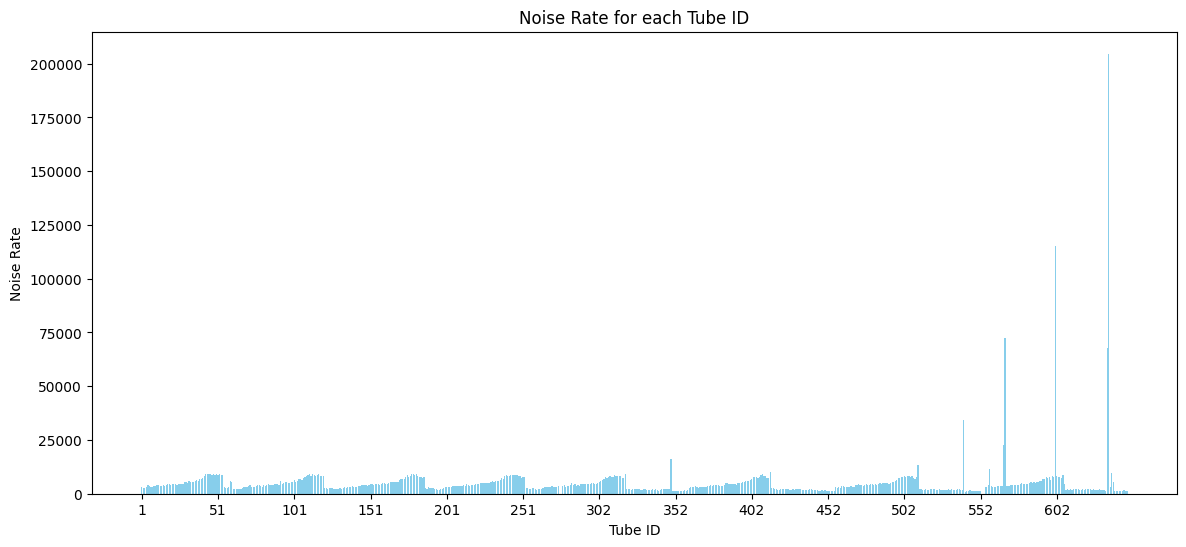

In [22]:
adc_cut=50
df_new_adc_cut=df_raw_chamber[df_raw_chamber['rawMdt_adc']>adc_cut]
extracted_df = extracted_df_for_noise_rate(df_new_adc_cut,'BIS7A16')
plot_for_noise_rate(extracted_df)

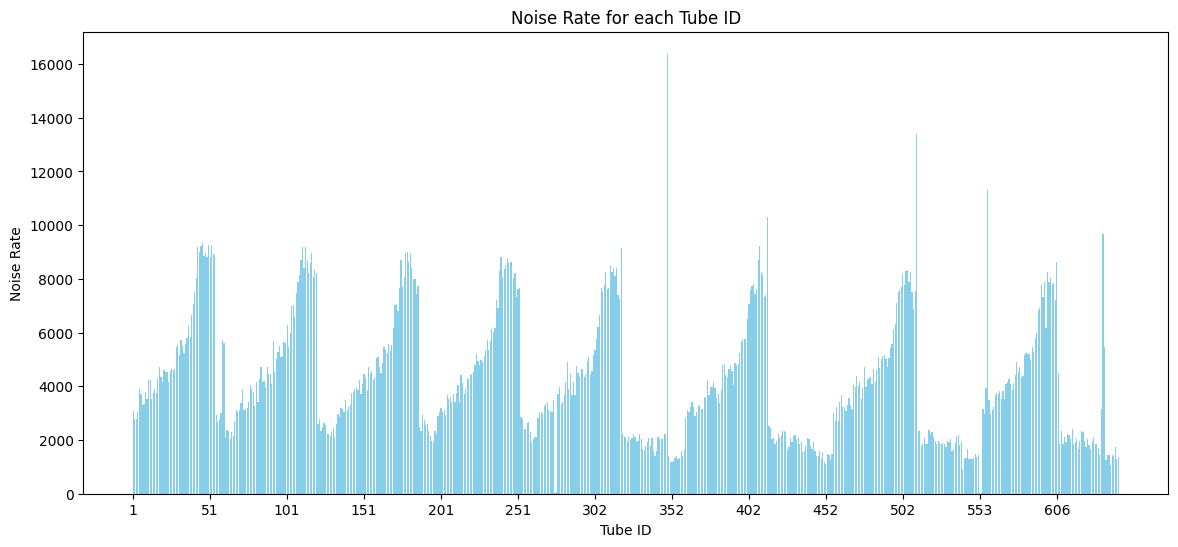

In [46]:
#extracting all tubes having noisy_rate more than 20k
extracted_df_aftr_removing_noisy_tubes=extracted_df[extracted_df['Noise_rate']<20000]
extracted_df_aftr_removing_noisy_tubes
plot_for_noise_rate(extracted_df_aftr_removing_noisy_tubes)

In [140]:
noisy_tubes=extracted_df[extracted_df['Noise_rate']>20000]
noisy_list=noisy_tubes['index']
# tube_name_list=data(lambda x: )
noisy_tube_names=data.loc[data['Tube_ID'].isin(noisy_list)]
noisy_tube_names

,Tube Name,Noise Rate,Tube_ID
0,BIS7A16-2-4-49,493554.980179,601
1,BIS7A16-2-4-16,299167.309498,568
2,BIS7A16-2-4-15,246987.235808,567
3,BIS7A16-2-4-84,238713.932476,636
4,BIS7A16-2-4-83,202427.923214,635
7,BIS7A16-2-3-85,151249.967956,541


In [139]:
data['Tube_ID','Tube_Name']

KeyError: ('Tube_ID', 'Tube_Name')

## Plot after adc cut

# Trials

In [70]:
#Noise rate
def noise_rate(df, chamber):
    df_raw_chamber = df[df['rawMdt_station']==chamber]
    
    tube_hits=df_raw_chamber.rawMdt_tubeInfo.value_counts()
    
    # # N = tube_hits
    # tube_hits.columns = ['rawMdt_tubeInfo', 'hits_per_tube']
    # # df_raw_chamber=df_raw_chamber.merge(hits_per_tube, on='rawMdt_tubeInfo', how='left')
    act_time_window=1.3*(10**(-6))
    total_evts=33007
    # tube_hits['noise_rate']=tube_hits['hits_per_tube']/(act_time_window*total_evts)
    noise_rate=tube_hits/(act_time_window*total_evts)
    return noise_rate
 
noise_ = noise_rate(df_raw, 'BIS7A16')
idxs = noise_.index

tube_dict = data_for_chamber(df_raw, 'BIS7A16')

hit_freq_dict = {}
for i in idxs:
    tube_idx = tube_dict[i]
    hit_freq = noise_[i]
    hit_freq_dict[tube_idx] = hit_freq

df_new=pd.DataFrame(hit_freq_dict.values(),hit_freq_dict.keys())
df_new=df_new.reset_index()
df_new

,index,0
0,601,493554.980179
1,568,299167.309498
2,567,246987.235808
3,636,238713.932476
4,635,202427.923214
...,...,...
642,452,1281.779389
643,276,186.440638
644,275,116.525399
645,553,93.220319


In [56]:
#Noise rate
def noise_rate(df, chamber):
    df_raw_chamber = df[df['rawMdt_station']==chamber]
    
    tube_hits=df_raw_chamber.rawMdt_tubeInfo.value_counts()
    
    # # N = tube_hits
    # tube_hits.columns = ['rawMdt_tubeInfo', 'hits_per_tube']
    # # df_raw_chamber=df_raw_chamber.merge(hits_per_tube, on='rawMdt_tubeInfo', how='left')
    act_time_window=1.3*(10**(-6))
    total_evts=33007
    # tube_hits['noise_rate']=tube_hits['hits_per_tube']/(act_time_window*total_evts)
    noise_rate=tube_hits/(act_time_window*total_evts)
    return noise_rate
 
noise_ = noise_rate(df_raw, 'BIS7A16')   #this is a series
idxs = noise_.index                       #index of pandas series
# print(type(idxs))

tube_dict = data_for_chamber(df_raw, 'BIS7A16')   #called the function from previous code here

hit_freq_dict = {}      #created an empty dictionary
for i in idxs:
    tube_idx = tube_dict[i]
    hit_freq = noise_[i]    #noise_[i] gives value of noise rate for that particular tube, which is the i, cz that is the index of noise rate
    hit_freq_dict[tube_idx] = hit_freq   

df_new=pd.DataFrame(hit_freq_dict.values(),index=hit_freq_dict.keys())
df_new


,0
601,493554.980179
568,299167.309498
567,246987.235808
636,238713.932476
635,202427.923214
...,...
452,1281.779389
276,186.440638
275,116.525399
553,93.220319


In [17]:
def new_data(df, chamber):
    df_raw_chamber = df[df['rawMdt_station']==chamber]
    # print(df_raw_chamber)

    def calculate_tube_index():
        chamberinfo = list(df_raw_chamber.rawMdt_tubeInfo)
        tube_index=[]
        ch=[]
        tube_chamber_mapping={}
        for x in chamberinfo:
            ml_index=int(x.split('-')[1])
            ly_index =int(x.split('-')[2])
        # nLayer = (int(x.split('-')[1])-1)*4 + int(x.split('-')[2])
            tube_id =int(x.split('-')[3])
        # tubes_per_layer=chamberlist_run3.MDTnTly( chamber, 1 )  #(chamber,ml)
        # layers_per_ml=chamberlist_run3.MDTnLml( chamber, 1 )
        # tube_index_ml=(ml_index-1)*chamberlist_run3.MDTnTml(chamber,0) + (ly_index-1)*chamberlist_run3.MDTnTly(chamber,ml_index
                                                                                                          # ) + tube_id
            tube_index_ml=(ml_index-1)*chamberlist_run3.MDTnTml(chamber,1) + (ly_index-1)*chamberlist_run3.MDTnTly(chamber,ml_index) + tube_id
            return tube_index
      #apply function to each row of dataframe  
    new_df['tube_index']=new_df.apply(calculate_tube_index, axis=1)
    #calculate frequency of each rawMdt_tubeinfo value
    new_df=new_df.drop_duplicates().reset_index(drop=True)

    #show the resulting dataframe
    print(new_df)
new_data(df_raw,'BIS7A16')

UnboundLocalError: cannot access local variable 'new_df' where it is not associated with a value

In [22]:
def calculate_tube_index(df,chamberlist_run3):
    # Extract the information from the rawMdt_tubeinfo field
    parts = df['rawMdt_tubeInfo'].split('_')
    mL_index = int(parts[1])
    ly_index = int(parts[2])
    tube_id = int(parts[3])
    
    # Calculate the tube index using the provided logic and the chamberlist_run3 object
    tube_index_mL = (mL_index - 1) * chamberlist_run3.MDTrnTmL(df['rawMdt_station'], mL_index)
    tube_index_ly = (ly_index - 1) * chamberlist_run3.MDTrnTy(df['rawMdt_station'], mL_index)
    tube_index = tube_index_mL + tube_index_ly + tube_id
    
    return tube_index

def new_data(df, chamber):
    # Filter the DataFrame for the specified chamber
    df_raw_chamber = df[df['rawMdt_station'] == chamber]
    
    # Apply the calculate_tube_index function to each row of the filtered DataFrame
    df_raw_chamber['tube_index'] = df_raw_chamber.apply(calculate_tube_index, axis=1, chamberlist_run3=chamberlist_run3)
    
    # Create a new DataFrame to calculate the frequency of each rawMdt_tubeinfo value
    new_df = pd.DataFrame(df_raw_chamber['rawMdt_tubeInfo'].value_counts()).reset_index()
    new_df.columns = ['rawMdt_tubeInfo', 'frequency']
    
    # Add the tube_index to the new DataFrame
    new_df['tube_index'] = new_df['rawMdt_tubeInfo'].apply(lambda x: calculate_tube_index(df_raw_chamber[df_raw_chamber['rawMdt_tubeInfo'] == x].iloc[0], chamberlist_run3))
    
    # Reset index and return the new DataFrame
    new_df = new_df.reset_index(drop=True)
    return new_df

# Assuming chamberlist_run3 is defined in your environment and the DataFrame df is already loaded
new_data(df_raw, 'BIS7A16')


IndexError: list index out of range

In [15]:
def new_data(df, chamber):
    df_raw_chamber = df[df['rawMdt_station']==chamber]
    df_raw_chamber['Chamber'],df_raw_chamber['ml_index'],df_raw_chamber['ly_index'],df_raw_chamber['tube_id']=zip(*df_raw_chamber['rawMdt_tubeInfo'].apply(lambda x:x.split('-')))

    #convert to integer type as necessary
    df_raw_chamber['ml_index']=df_raw_chamber['ml_index'].astype(int)
    df_raw_chamber['ly_index']=df_raw_chamber['ly_index'].astype(int)
    df_raw_chamber['tube_id']=df_raw_chamber['tube_id'].astype(int)

    df_raw_chamber['tube_index']= (df_raw_chamber['ml_index']-1)*chamberlist_run3.MDTnTml(chamber,1) + (df_raw_chamber['ly_index']-1)*chamberlist_run3.MDTnTly(chamber,df_raw_chamber['ml_index']) + df_raw_chamber['tube_id']

    # Create a new DataFrame with the needed columns
    new_df = pd.DataFrame({
    'rawMdt_tubeinfo': df_raw_chamber['rawMdt_tubeinfo'],
    'tube_index': df_raw_chamber['tube_index']})

    # Calculate the frequency of each rawMdt_tubeinfo value
    new_df['frequency'] = new_df.groupby('rawMdt_tubeinfo')['rawMdt_tubeinfo'].transform('count')

    # If you want to drop duplicates so each rawMdt_tubeinfo appears once with its frequency
    new_df = new_df.drop_duplicates().reset_index(drop=True)

    # Show the resulting dataframe
    print(new_df)
new_data(df_raw,'BIS7A16')

/var/folders/w3/c0s4x6mj0rd2h643_w1y144r0000gn/T/ipykernel_3715/3125481850.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw_chamber['Chamber'],df_raw_chamber['ml_index'],df_raw_chamber['ly_index'],df_raw_chamber['tube_id']=zip(*df_raw_chamber['rawMdt_tubeInfo'].apply(lambda x:x.split('-')))
/var/folders/w3/c0s4x6mj0rd2h643_w1y144r0000gn/T/ipykernel_3715/3125481850.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw_chamber['Chamber'],df_raw_chamber['ml_index'],df_raw_chamber['ly_index'],df_

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [12]:
index_values=data_for_chamber(df_raw, 'BIS7A16')
index_values
# len(index_values['Tube_Index'].unique())


AttributeError: 'list' object has no attribute 'map'

,Chamberinfo,Tube_Index
0,BIS7A16-2-4-94,646
1,BIS7A16-2-4-86,638
2,BIS7A16-2-4-84,636
3,BIS7A16-2-4-84,636
4,BIS7A16-2-4-83,635
...,...,...
278448,BIS7A16-1-3-10,142
278449,BIS7A16-1-2-31,97
278450,BIS7A16-1-1-52,52
278451,BIS7A16-2-4-49,601


In [27]:

def data_for_chamber(df, chamber):
    df_raw_chamber = df[df['rawMdt_station'] == chamber]
    # Assuming 'rawMdt_tubeInfo' contains strings formatted as 'chamber-ml-ly-tube'
    # Split the 'rawMdt_tubeInfo' column into separate columns
    split_columns = df_raw_chamber['rawMdt_tubeInfo'].str.split('-', expand=True)
    
    # Calculate tube_index (ensure you replace the placeholder calculations with your actual logic)
    df_raw_chamber['tube_index'] = (
        (split_columns[1].astype(int) - 1) * chamberlist_run3.MDTnTml(chamber, 1) +
        (split_columns[2].astype(int) - 1) * chamberlist_run3.MDTnTly(chamber, split_columns[1].astype(int)) +
        split_columns[3].astype(int)
    )

    # Drop duplicates based on the 'tube_index' to get unique values
    df_unique = df_raw_chamber.drop_duplicates(subset='tube_index')
    
    # Create a dictionary for the DataFrame
    data_dict = {'Chamberinfo': df_unique['rawMdt_tubeInfo'], 'Tube_Index': df_unique['tube_index']}
    
    return pd.DataFrame(data_dict)
index_values=data_for_chamber(df_raw, 'BIS7A16')
index_values

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

# Hitmap plots

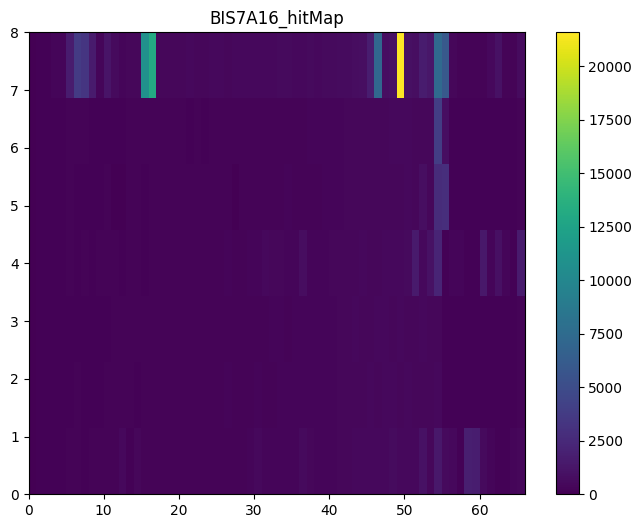

rawMdt_tubeInfo
BIS7A16-2-4-49    21178
BIS7A16-2-4-16    12837
BIS7A16-2-4-15    10598
BIS7A16-2-4-84    10243
BIS7A16-2-4-83     8686
                  ...  
BIS7A16-2-2-92       55
BIS7A16-2-1-12        8
BIS7A16-2-1-11        5
BIS7A16-2-4-1         4
BIS7A16-2-4-2         2
Name: count, Length: 647, dtype: int64


In [27]:
# plotting function for chamber hitMap and noise_hits  
def plotHitMap(df,chamber):
    df_raw_chamber = df[df['rawMdt_station']==chamber]
    
    chamberinfo = list(df_raw_chamber.rawMdt_tubeInfo)
    #apply to ML-Layer-Tube columns
    ml =[int(x.split('-')[1]) for x in chamberinfo]
    ly =[int(x.split('-')[2]) for x in chamberinfo]
    nLayer = [(int(x.split('-')[1])-1)*4 + int(x.split('-')[2]) for x in chamberinfo]
    tb =[int(x.split('-')[3]) for x in chamberinfo]

    fig,ax = plt.subplots(figsize=(8,6))
    ax.set_title(f'{chamber}_hitMap')
    
    # get Maxtube per layer and total layer from chamberlist_run3.py
    maxLy = chamberlist_run3.MDTtotalLayers(chamber)
    maxTb = chamberlist_run3.MDTtotalTubes(chamber)
    
    counts, xedges, yedges, im = ax.hist2d(tb,nLayer, bins = [66,7], range= [[0,66],[0,8]], cmap=plt.cm.viridis,label='hitMap')
    fig.colorbar(im, ax=ax)
    plt.show()
    # fig.savefig(f'run456729_{chamber}_hitMap_before_noise.png')

    #get hits from all tubes
    hit_info=df.rawMdt_tubeInfo.value_counts()
    # print(hit_info)
plotHitMap(df_raw_chamber,'BIS7A16')  #crude plot

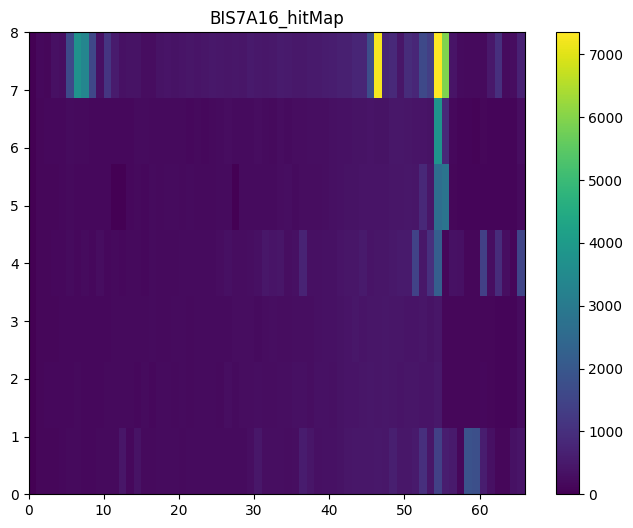

rawMdt_tubeInfo
BIS7A16-2-4-46    6839
BIS7A16-2-4-54    6833
BIS7A16-2-4-82    4588
BIS7A16-2-2-54    3810
BIS7A16-2-4-6     3591
                  ... 
BIS7A16-2-2-92      55
BIS7A16-2-1-12       8
BIS7A16-2-1-11       5
BIS7A16-2-4-1        4
BIS7A16-2-4-2        2
Name: count, Length: 641, dtype: int64


In [173]:
plotHitMap(df_raw_chamber_noisy_filtered,'BIS7A16')

27

In [ ]:
ml=[0,1]
tube_per_layer=2
layer_index=[0,1]
tubes=3
tube_num=[6,4,3,2,1,7,9,8,12,10,11]

In [ ]:
tube_index=ML*(Total tubes per ml)+layer*(total tube per layer)+tube

# Adc cut dataset

In [6]:
# raw ADC and TDC hits plot with and without ADC cut at 50
def plotRawMdtHits(df,chamber):
    
    df_raw_chamber = df[df['rawMdt_station']==chamber]
    
    #remove noisy tubes from the dataset
    from noisy_tubes import tb
    
    adc_cut = 50
    # df_raw_chamber_with_cut = df_raw_chamber[df_raw_chamber['rawMdt_adc']>adc_cut]
    df_raw_chamber_with_cut = df_raw_chamber[df_raw_chamber['rawMdt_adc']>adc_cut]

    df_raw_chamber_filtered=df_raw_chamber_with_cut[~df_raw_chamber_with_cut['rawMdt_tubeInfo'].isin(tb)]
    print(df_raw_chamber_filtered)
    
    # make chamber overall info
    run = '456729'
    fig,axes = plt.subplots(figsize=(32, 24), nrows = 3, ncols = 3)
    fig.subplots_adjust(top = 0.93, bottom = 0.05, left =0.02,right =0.95, wspace = 0.2, hspace = 0.2)
    fig.suptitle('run%s_%s_rawMdtHit_Plots'%(run,chamber), fontsize=20)

    #hitmap without adc
    # ADC count without cut
    mdt_adc = df_raw_chamber.rawMdt_adc.values.astype(float)
    min_adc = -50
    max_adc = 400
    
    xadc, xbins, patch = axes[0,0].hist(mdt_adc,bins=max_adc-min_adc,range=[min_adc,max_adc],label = 'adc')
    mean = np.average(mdt_adc)
    std = np.sqrt(np.average((mdt_adc - mean)**2))
    axes[0,0].set_xlim(min_adc,max_adc)
    axes[0,0].set_xlabel('adcCount',fontsize=15)
    axes[0,0].text(270,np.max(xadc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xadc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[0,0].grid()
    axes[0,0].set_title(f'{chamber}_rawADC')
    
    mdt_adc_cut = df_raw_chamber_with_cut.rawMdt_adc.values.astype(float)
    
    xadc, xbins, patch = axes[1,0].hist(mdt_adc_cut,bins=max_adc-min_adc,range=[min_adc,max_adc],label = 'adc')
    mean = np.average(mdt_adc_cut)
    std = np.sqrt(np.average((mdt_adc_cut - mean)**2))
    axes[1,0].set_xlim(min_adc,max_adc)
    axes[1,0].set_xlabel('adcCount',fontsize=15)
    axes[1,0].text(270,np.max(xadc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xadc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[1,0].grid()
    axes[1,0].set_title(f'{chamber}_rawADC_adcCut{adc_cut}')

    mdt_adc_cut_filtered = df_raw_chamber_filtered.rawMdt_adc.values.astype(float)
    
    xadc, xbins, patch = axes[2,0].hist(mdt_adc_cut_filtered,bins=max_adc-min_adc,range=[min_adc,max_adc],label = 'adc')
    mean = np.average(mdt_adc_cut)
    std = np.sqrt(np.average((mdt_adc_cut_filtered - mean)**2))
    axes[2,0].set_xlim(min_adc,max_adc)
    axes[2,0].set_xlabel('adcCount',fontsize=15)
    axes[2,0].text(270,np.max(xadc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xadc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[2,0].grid()
    axes[2,0].set_title(f'{chamber}_rawADC_adcCut{adc_cut}')
    
    # raw TDC spectrum
    mdt_tdc = df_raw_chamber.rawMdt_tdc.values.astype(float)
    min_tdc = -50
    max_tdc = 1650
    xtdc, xbins, patch = axes[0,1].hist(mdt_tdc,bins= max_tdc-min_tdc,range=[min_tdc,max_tdc],label = 'tdc')
    axes[0,1].set_xlim(min_tdc,max_tdc)
    axes[0,1].set_xlabel('tdcCount',fontsize=15)
    axes[0,1].text(700,np.max(xtdc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xtdc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[0,1].grid()
    axes[0,1].set_title(f'{chamber}_rawTDC')

    
    mdt_tdc_cut = df_raw_chamber_with_cut.rawMdt_tdc.values.astype(float)
    xtdc, xbins, patch = axes[1,1].hist(mdt_tdc_cut,bins= max_tdc-min_tdc,range=[min_tdc,max_tdc],label = 'tdc')
    axes[1,1].set_xlim(min_tdc,max_tdc)
    axes[1,1].set_xlabel('tdcCount',fontsize=15)
    axes[1,1].text(700,np.max(xtdc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xtdc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[1,1].grid()
    axes[1,1].set_title(f'{chamber}_rawTDC_adcCut{adc_cut}')

    
    mdt_tdc_cut_filtered = df_raw_chamber_filtered.rawMdt_tdc.values.astype(float)
    xtdc, xbins, patch = axes[1,1].hist(mdt_tdc_cut_filtered,bins= max_tdc-min_tdc,range=[min_tdc,max_tdc],label = 'tdc')
    axes[2,1].set_xlim(min_tdc,max_tdc)
    axes[2,1].set_xlabel('tdcCount',fontsize=15)
    axes[2,1].text(700,np.max(xtdc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xtdc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[2,1].grid()
    axes[2,1].set_title(f'{chamber}_rawTDC_adcCut{adc_cut}')
   #  # fit t0
   #  # driftTime spectrum
   #  #t0_fit,tmax_fit, axes[0,2] = mdtCalib_functions.fitT0Tmax(mdt_tdc_cut,chamber,axes[0,2])
    
   #Hitmap after removing noise 
    Chamberinfo = list(df_raw_chamber.rawMdt_tubeInfo)
    #apply to ML-Layer-Tube columns
    ml =[int(x.split('-')[1]) for x in Chamberinfo]
    ly =[int(x.split('-')[2]) for x in Chamberinfo]
    nLayer = [(int(x.split('-')[1])-1)*4 + int(x.split('-')[2]) for x in Chamberinfo]
    ntb =[int(x.split('-')[3]) for x in Chamberinfo]
    axes[0,2].set_title(f'{chamber}_hitMap_filtered')
    
    # get Maxtube per layer and total layer from chamberlist_run3.py
    maxLy = chamberlist_run3.MDTtotalLayers(chamber)
    maxTb = chamberlist_run3.MDTtotalTubes(chamber)
    
    counts, xedges, yedges, im = axes[0,2].hist2d(ntb,nLayer, bins = [66,7], range= [[0,66],[0,8]], cmap=plt.cm.viridis,label='hitMap')
    fig.colorbar(im, ax=axes[0,2])
    #mdtCalib_functions.fitResidual(x1,bins1,'Residual_unbias',ax)
    
    chamberinfo_cut = list(df_raw_chamber_with_cut.rawMdt_tubeInfo)
    # apply to ML-Layer-Tube columns
    ml =[int(x.split('-')[1]) for x in chamberinfo_cut]
    ly =[int(x.split('-')[2]) for x in chamberinfo_cut]
    nLayer = [(int(x.split('-')[1])-1)*4 + int(x.split('-')[2]) for x in chamberinfo_cut]
    ntb =[int(x.split('-')[3]) for x in chamberinfo_cut]
    axes[2,2].set_title(f'{chamber}_hitMap_adcCut_filtered')
    
    counts, xedges, yedges, im = axes[2,2].hist2d(ntb,nLayer, bins = [66,7], range= [[0,66],[0,8]], cmap=plt.cm.viridis,label='hitMap')
    fig.colorbar(im, ax=axes[2,2])

    chamberinfo_cut = list(df_raw_chamber_filtered.rawMdt_tubeInfo)
    # apply to ML-Layer-Tube columns
    ml =[int(x.split('-')[1]) for x in chamberinfo_cut]
    ly =[int(x.split('-')[2]) for x in chamberinfo_cut]
    nLayer = [(int(x.split('-')[1])-1)*4 + int(x.split('-')[2]) for x in chamberinfo_cut]
    ntb =[int(x.split('-')[3]) for x in chamberinfo_cut]
    axes[2,2].set_title(f'{chamber}_hitMap_adcCut_filtered')
    
    counts, xedges, yedges, im = axes[2,2].hist2d(ntb,nLayer, bins = [66,7], range= [[0,66],[0,8]], cmap=plt.cm.viridis,label='hitMap')
    fig.colorbar(im, ax=axes[2,2])
    
    fig.patch.set_facecolor('white')
    # fig.savefig(f'run456729_{chamber}_rawMdtHit.png')
    plt.show()
    
plotRawMdtHits(df_raw,'BIS7A16')


                rawMdt_adc  rawMdt_gPosX  rawMdt_gPosY  rawMdt_gPosZ  \
entry subentry                                                         
1     0                242   4313.193848  -1786.583252   7326.850098   
      12               128   4301.101074  -1781.574341   6972.000000   
3     4                141   4313.193848  -1786.583252   6843.649902   
      5                146   4313.193848  -1786.583252   6828.549805   
      7                 96   4301.101074  -1781.574341   6805.899902   
...                    ...           ...           ...           ...   
33004 14               136   4222.755859  -1749.122803   6383.100098   
      15               121   4222.755859  -1749.122803   6352.899902   
      16               164   4222.755859  -1749.122803   6050.899902   
      17               174   4210.663086  -1744.113892   6375.549805   
33005 14               146   4222.755859  -1749.122803   6186.799805   

                rawMdt_id  rawMdt_nRMdt  rawMdt_tdc rawMdt_tube

ValueError: Image size of 3060x111675 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 3200x2400 with 12 Axes>

In [172]:
df_raw_chamber_noisy_filtered=df_raw_chamber[~df_raw_chamber['rawMdt_tubeInfo'].isin(noisy_tube_names['Tube Name'])]
df_raw_chamber_noisy_filtered

rawMdt_adc  rawMdt_gPosX  rawMdt_gPosY  rawMdt_gPosZ  \
entry subentry                                                         
1     0                242   4313.193848  -1786.583252   7326.850098   
      1                 36   4313.193848  -1786.583252   7206.049805   
      5                 36   4313.193848  -1786.583252   7145.649902   
      6                 35   4313.193848  -1786.583252   6722.850098   
      11                35   4301.101074  -1781.574341   7198.500000   
...                    ...           ...           ...           ...   
33004 15               121   4222.755859  -1749.122803   6352.899902   
      16               164   4222.755859  -1749.122803   6050.899902   
      17               174   4210.663086  -1744.113892   6375.549805   
      18                35   4198.570801  -1739.104858   6685.100098   
33005 14               146   4222.755859  -1749.122803   6186.799805   

                rawMdt_id  rawMdt_nRMdt  rawMdt_tdc rawMdt_tubeInfo  \
entry subentry                                                        
1     0          24707037           101         712  BIS7A16-2-4-94   
      1          24707029           101         151  BIS7A16-2-4-86   
      5          24707025           101        1406  BIS7A16-2-4-82   
      6          24706997           101         494  BIS7A16-2-4-54   
      11         24706901           101         286  BIS7A16-2-3-86   
...                   ...           ...         ...             ...   
33004 15         24706333           117         402  BIS7A16-1-3-30   
      16         24706313           117         183  BIS7A16-1-3-10   
      17         24706206           117         341  BIS7A16-1-2-31   
      18         24706099           117        1441  BIS7A16-1-1-52   
33005 14         24706322           146         298  BIS7A16-1-3-19   

               rawMdt_station rawMdt_type  
entry subentry                             
1     0               BIS7A16         BIS  
      1               BIS7A16         BIS  
      5               BIS7A16         BIS  
      6               BIS7A16         BIS  
      11              BIS7A16         BIS  
...                       ...         ...  
33004 15              BIS7A16         BIS  
      16              BIS7A16         BIS  
      17              BIS7A16         BIS  
      18              BIS7A16         BIS  
33005 14              BIS7A16         BIS  

[208421 rows x 10 columns]

In [16]:
#plot after removing noise
def plotHitMap_after_noise(chamber):
    
    # df_raw_chamber = df_raw[df_raw['rawMdt_station']==chamber]

    chamberinfo = list(df_raw_chamber.rawMdt_tubeInfo)
    #apply to ML-Layer-Tube columns
    ml =[int(x.split('-')[1]) for x in chamberinfo]
    ly =[int(x.split('-')[2]) for x in chamberinfo]
    nLayer = [(int(x.split('-')[1])-1)*4 + int(x.split('-')[2]) for x in chamberinfo]
    tb =[int(x.split('-')[3]) for x in chamberinfo]

    fig,ax = plt.subplots(figsize=(8,6))
    ax.set_title(f'{chamber}_hitMap_after_noise')
    
    # get Maxtube per layer and total layer from chamberlist_run3.py
    maxLy = chamberlist_run3.MDTtotalLayers(chamber)
    maxTb = chamberlist_run3.MDTtotalTubes(chamber)
    
    counts, xedges, yedges, im = ax.hist2d(tb,nLayer, bins = [66,7], range= [[0,66],[1,8]], cmap=plt.cm.viridis,label='hitMap')
    fig.colorbar(im, ax=ax)
    plt.show()
    fig.savefig(f'run456729_{chamber}_hitMap_after_noise.png')

    # #get hits from all tubes
    # hit_info=df_raw_chamber.rawMdt_tubeInfo.value_counts()
    # print(hit_info)
plotHitMap('BIS7A16')

NameError: name 'BIS7A16' is not defined

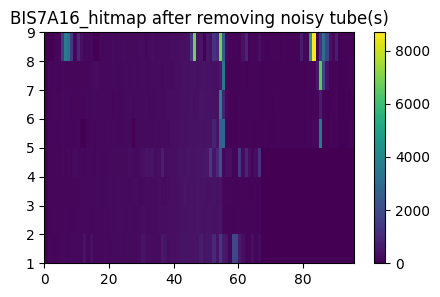

In [186]:
#plot after removing noise

# df_raw_chamber_nr = df_raw_chamber[(df_raw_chamber['rawMdt_tubeInfo'] != 'BIS7A16-2-4-49') & (df_raw_chamber['rawMdt_tubeInfo'] != 'BIS7A16-2-4-16')
# & (df_raw_chamber['rawMdt_tubeInfo'] != 'BIS7A16-2-4-15') & (df_raw_chamber['rawMdt_tubeInfo'] != 'BIS7A16-2-4-84') ]
# df_raw_chamber_nr

df_raw_chamber_nr=df_raw_chamber[df_raw_chamber[x] for x in noisy_tubes]

chamberinfo = list(df_raw_chamber_nr.rawMdt_tubeInfo)
# chamberinfo=list(df_trk_chamber.trkHit_tubeInfo)
# chamberinfo   #extracted all chamber name as a list
#apply to ML-Layer-Tube columns
ml =[int(x.split('-')[1]) for x in chamberinfo]
# ml   #BIS7A16-2-4-83
ly =[int(x.split('-')[2]) for x in chamberinfo]
nLayer = [(int(x.split('-')[1])-1)*4 + int(x.split('-')[2]) for x in chamberinfo]  #no of layers maybe?
tb =[int(x.split('-')[3]) for x in chamberinfo]
tb    #tube number
# get Maxtube per layer and total layer from chamberlist_run3.py
maxLy = chamberlist_run3.MDTtotalLayers('BIS7A16')
maxTb = chamberlist_run3.MDTtotalTubes('BIS7A16')
# maxLy, maxTb

#plot
fig,ax=plt.subplots(figsize=(5,3))
ax.set_title('BIS7A16_hitmap after removing noisy tube(s)')
count_r, xedges, yedges, im = ax.hist2d(tb,nLayer, bins = [96,8], range= [[0,96],[1,9]], cmap=plt.cm.viridis,label='hitMap')  #tb, nLayers why use?
fig.colorbar(im, ax=ax)
# fig.savefig('BIS7A16_hitMap_after_noise.png')
plt.show()

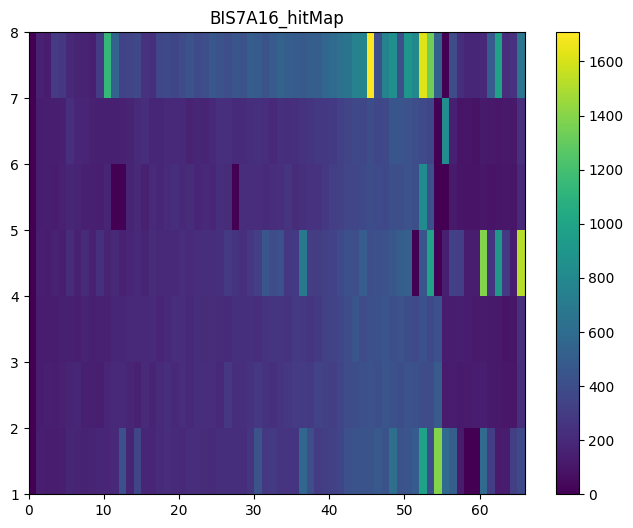

In [17]:
# plotting function for channel hitMap before removing the noisy tube
def plotHitMap(df, chamber):
    
    # pd_mdt_chamber = df_all[df_all['rawMdt_station']==chamber]

    chamberinfo = list(df.rawMdt_tubeInfo)
    #apply to ML-Layer-Tube columns
    ml =[int(x.split('-')[1]) for x in chamberinfo]
    ly =[int(x.split('-')[2]) for x in chamberinfo]
    nLayer = [(int(x.split('-')[1])-1)*4 + int(x.split('-')[2]) for x in chamberinfo]
    tb =[int(x.split('-')[3]) for x in chamberinfo]

    fig,ax = plt.subplots(figsize=(8,6))
    ax.set_title(f'{chamber}_hitMap')
    
    # get Maxtube per layer and total layer from chamberlist_run3.py
    maxLy = chamberlist_run3.MDTtotalLayers(chamber)
    maxTb = chamberlist_run3.MDTtotalTubes(chamber)
    
    counts, xedges, yedges, im = ax.hist2d(tb,nLayer, bins = [66,7], range= [[0,66],[1,8]], cmap=plt.cm.viridis,label='hitMap')
    fig.colorbar(im, ax=ax)
    plt.show()
    fig.savefig(f'run456729_{chamber}_hitMap_after_removing_noise.png')
    # return counts
    
plotHitMap(df_raw_chamber, 'BIS7A16')


In [89]:
df_raw_chamber['value_counts']=df_raw_chamber.apply(df_raw_chamber[df_raw_chamber['rawMdt_tubeInfo'].value_counts()])
df_raw_chamber

KeyError: "None of [Index([1760, 1707, 1701, 1445, 1416, 1409, 1394, 1388, 1351, 1333,\n       ...\n         60,   60,   60,   58,   57,   55,    8,    5,    4,    2],\n      dtype='int64', length=626)] are in the [columns]"

In [7]:
df_raw_chamber.rawMdt_adc.values.astype(float)

array([242., 128.,  33., ..., 174.,  35., 146.])

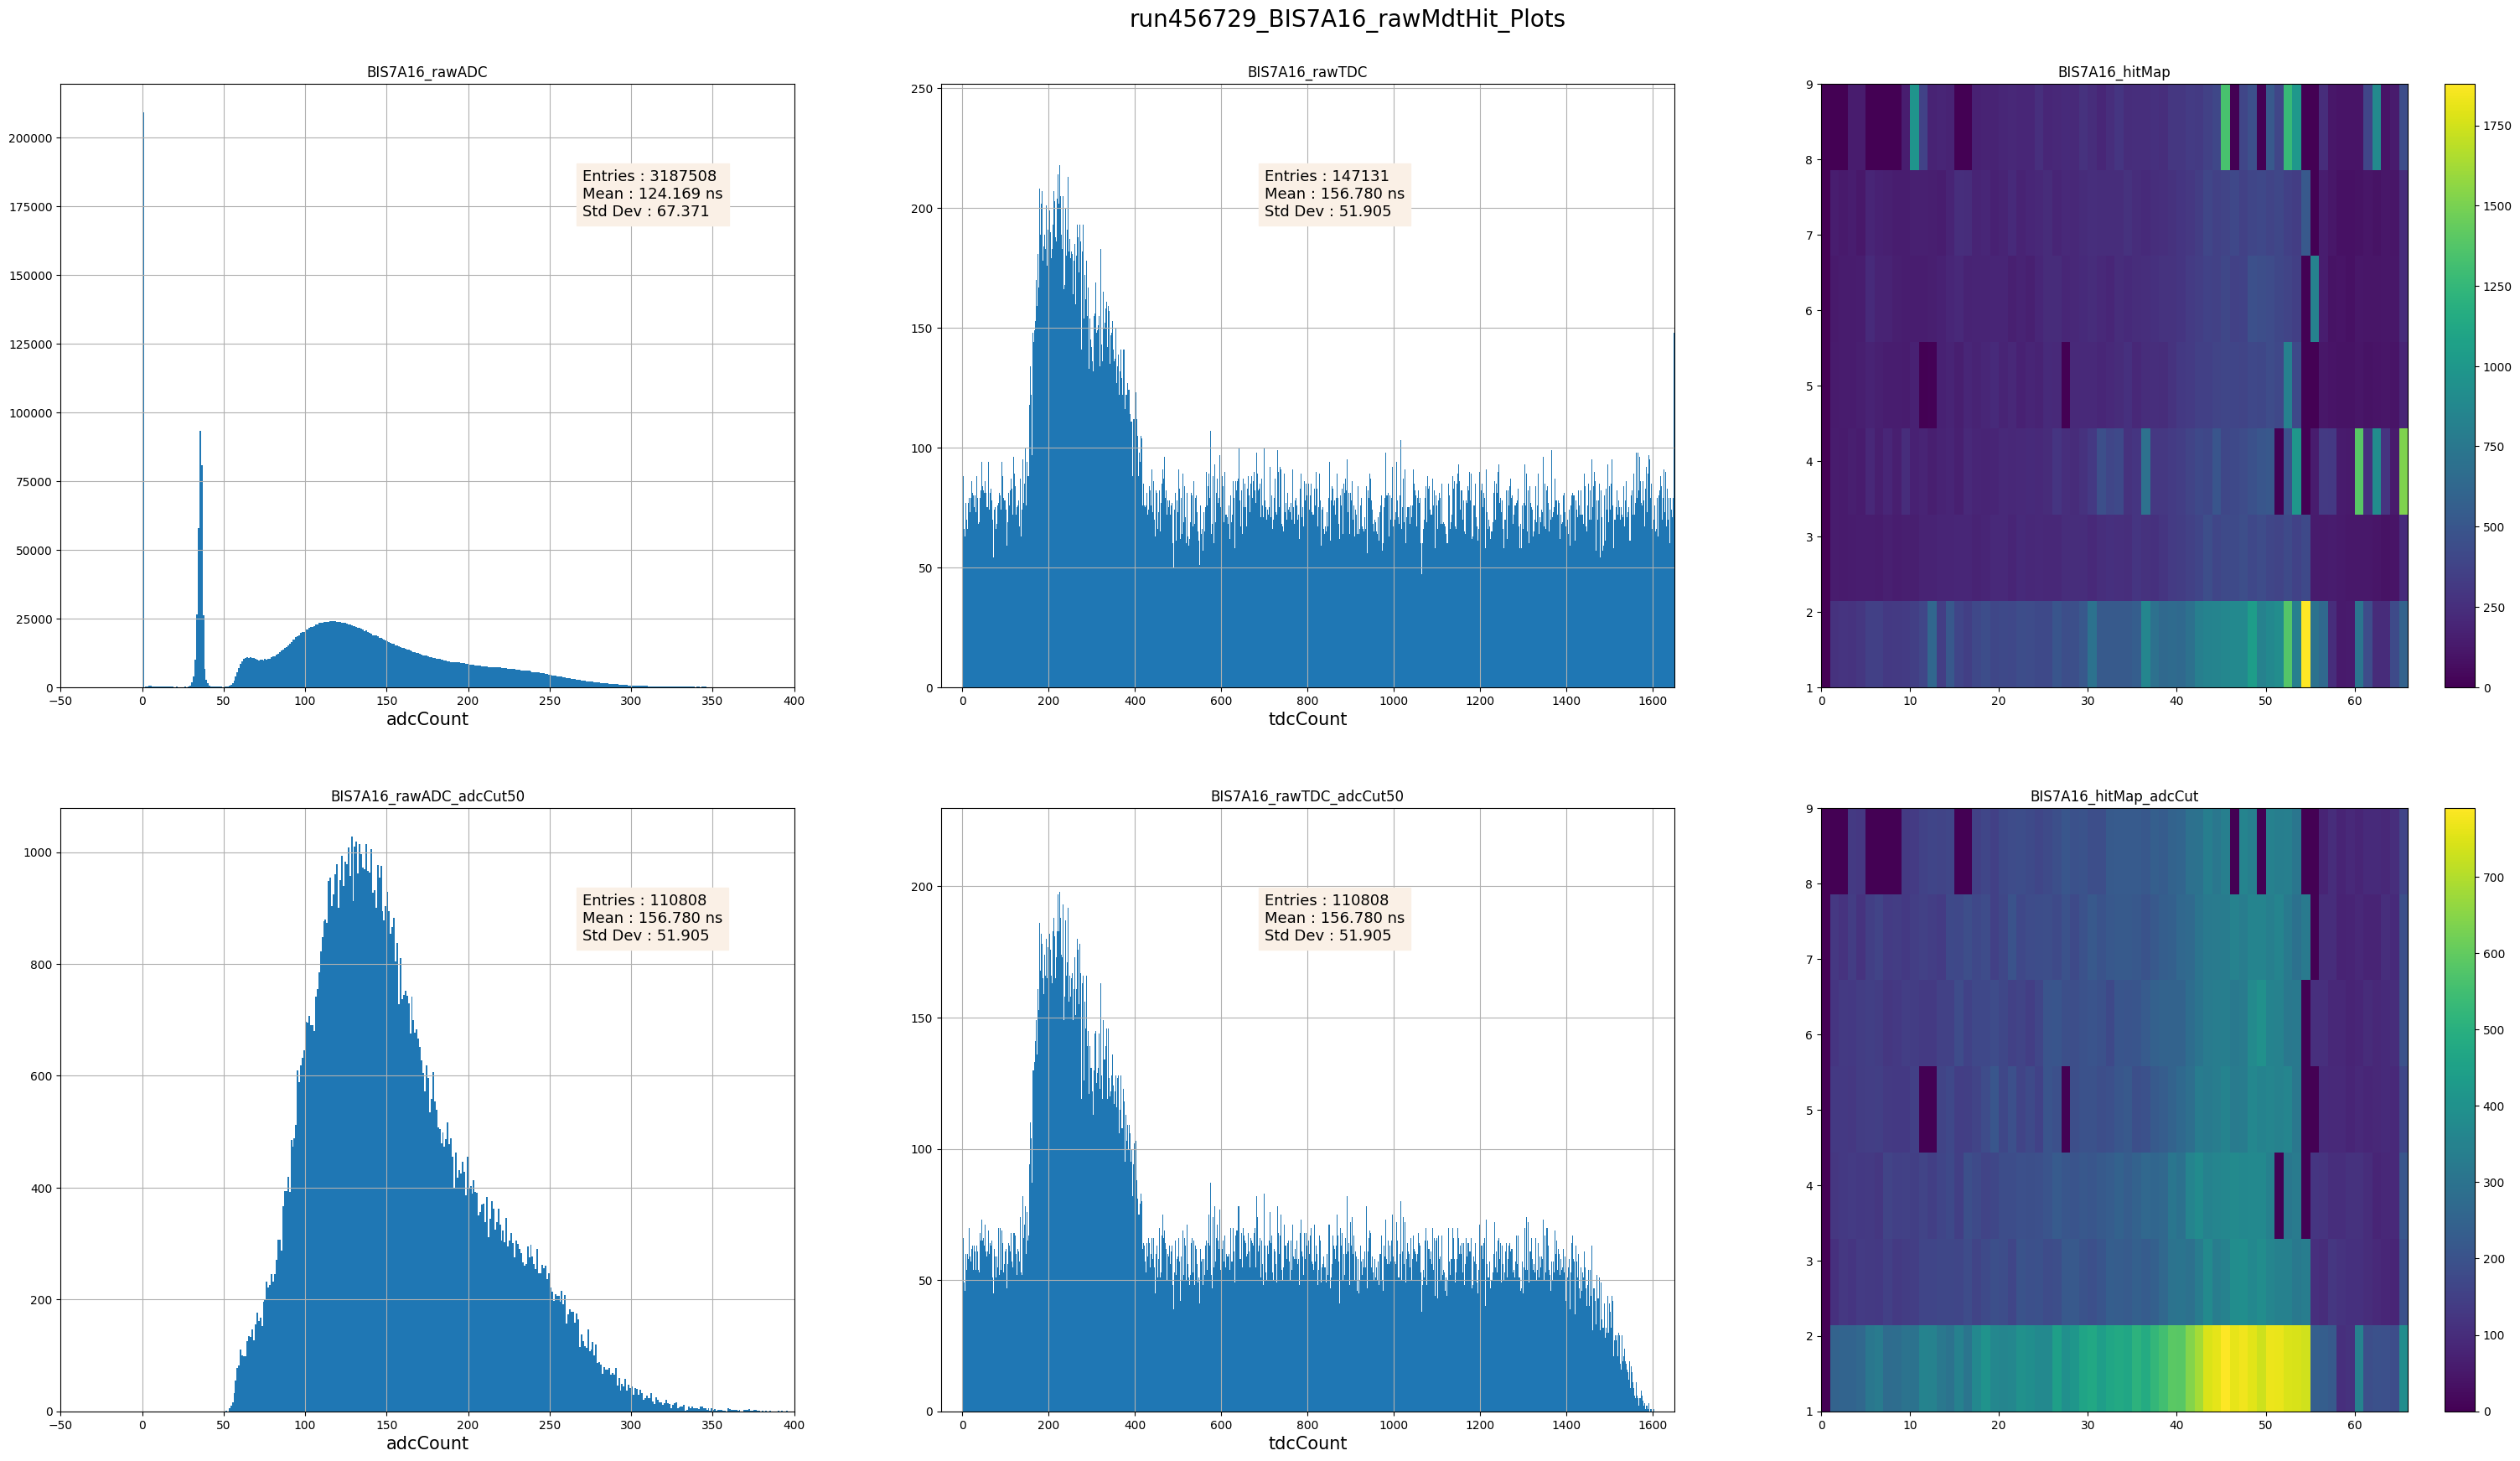

In [13]:
# raw ADC and TDC hits plot with and without ADC cut at 50
def plotRawMdtHits(df_raw_chamber,chamber):

    # pd_mdt_chamber = df_all[df_all['rawMdt_station']==chamber]
    adc_cut = 50
    df_raw_chamber_with_cut = df_raw_chamber[df_raw_chamber['rawMdt_adc']>adc_cut]
    
    # make chamber overall info
    run = '456729'
    fig,axes = plt.subplots(figsize=(32, 18), nrows = 3, ncols = 3)
    fig.subplots_adjust(top = 0.93, bottom = 0.05, left =0.02,right =0.95, wspace = 0.2, hspace = 0.2)
    fig.suptitle('run%s_%s_rawMdtHit_Plots'%(run,chamber), fontsize=20)
       
    # ADC count without cut
    mdt_adc = df_raw.rawMdt_adc.values.astype(float)
    min_adc = -50
    max_adc = 400
    xadc, xbins, patch = axes[0,0].hist(mdt_adc,bins=max_adc-min_adc,range=[min_adc,max_adc],label = 'adc')
    mean = np.average(mdt_adc)
    std = np.sqrt(np.average((mdt_adc - mean)**2))
    axes[0,0].set_xlim(min_adc,max_adc)
    axes[0,0].set_xlabel('adcCount',fontsize=15)
    axes[0,0].text(270,np.max(xadc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xadc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[0,0].grid()
    axes[0,0].set_title(f'{chamber}_rawADC')
    
    mdt_adc_cut = df_raw_chamber_with_cut.rawMdt_adc.values.astype(float)
    xadc, xbins, patch = axes[1,0].hist(mdt_adc_cut,bins=max_adc-min_adc,range=[min_adc,max_adc],label = 'adc')
    mean = np.average(mdt_adc_cut)
    std = np.sqrt(np.average((mdt_adc_cut - mean)**2))
    axes[1,0].set_xlim(min_adc,max_adc)
    axes[1,0].set_xlabel('adcCount',fontsize=15)
    axes[1,0].text(270,np.max(xadc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xadc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[1,0].grid()
    axes[1,0].set_title(f'{chamber}_rawADC_adcCut{adc_cut}')

    
    # raw TDC spectrum
    mdt_tdc = df_raw_chamber.rawMdt_tdc.values.astype(float)
    min_tdc = -50
    max_tdc = 1650
    xtdc, xbins, patch = axes[0,1].hist(mdt_tdc,bins= max_tdc-min_tdc,range=[min_tdc,max_tdc],label = 'tdc')
    axes[0,1].set_xlim(min_tdc,max_tdc)
    axes[0,1].set_xlabel('tdcCount',fontsize=15)
    axes[0,1].text(700,np.max(xtdc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xtdc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[0,1].grid()
    axes[0,1].set_title(f'{chamber}_rawTDC')

    
    mdt_tdc_cut = df_raw_chamber_with_cut.rawMdt_tdc.values.astype(float)
    xtdc, xbins, patch = axes[1,1].hist(mdt_tdc_cut,bins= max_tdc-min_tdc,range=[min_tdc,max_tdc],label = 'tdc')
    axes[1,1].set_xlim(min_tdc,max_tdc)
    axes[1,1].set_xlabel('tdcCount',fontsize=15)
    axes[1,1].text(700,np.max(xtdc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xtdc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[1,1].grid()
    axes[1,1].set_title(f'{chamber}_rawTDC_adcCut{adc_cut}')
    
    # fit t0
    # driftTime spectrum
    #t0_fit,tmax_fit, axes[0,2] = mdtCalib_functions.fitT0Tmax(mdt_tdc_cut,chamber,axes[0,2])
    
    
    chamberinfo = list(df_raw_chamber.rawMdt_tubeInfo)
    #apply to ML-Layer-Tube columns
    ml =[int(x.split('-')[1]) for x in chamberinfo]
    ly =[int(x.split('-')[2]) for x in chamberinfo]
    nLayer = [(int(x.split('-')[1])-1)*4 + int(x.split('-')[2]) for x in chamberinfo]
    tb =[int(x.split('-')[3]) for x in chamberinfo]
    axes[0,2].set_title(f'{chamber}_hitMap')
    
    # get Maxtube per layer and total layer from chamberlist_run3.py
    maxLy = chamberlist_run3.MDTtotalLayers(chamber)
    maxTb = chamberlist_run3.MDTtotalTubes(chamber)
    
    counts, xedges, yedges, im = axes[0,2].hist2d(tb,nLayer, bins = [66,7], range= [[0,66],[1,9]], cmap=plt.cm.viridis,label='hitMap')
    fig.colorbar(im, ax=axes[0,2])
    #mdtCalib_functions.fitResidual(x1,bins1,'Residual_unbias',ax)
    
    chamberinfo_cut = list(df_raw_chamber_with_cut.rawMdt_tubeInfo)
    #apply to ML-Layer-Tube columns
    ml =[int(x.split('-')[1]) for x in chamberinfo_cut]
    ly =[int(x.split('-')[2]) for x in chamberinfo_cut]
    nLayer = [(int(x.split('-')[1])-1)*4 + int(x.split('-')[2]) for x in chamberinfo_cut]
    tb =[int(x.split('-')[3]) for x in chamberinfo_cut]
    axes[1,2].set_title(f'{chamber}_hitMap_adcCut')
    
    counts, xedges, yedges, im = axes[1,2].hist2d(tb,nLayer, bins = [66,7], range= [[0,66],[1,9]], cmap=plt.cm.viridis,label='hitMap')
    fig.colorbar(im, ax=axes[1,2])
    
    fig.patch.set_facecolor('white')
    fig.savefig(f'run456729_{chamber}_rawMdtHit.png')
    plt.show()
    
plotRawMdtHits(df_raw_chamber,'BIS7A16')

In [167]:
# #before removing noise
# df=pd.DataFrame(count)
# df.columns=['ML1l1','ML1l2','ML1l3','ML1l4','ML2l1','ML2l2','ML2l3','ML2l4']
# df

#after removing noise
df_r=pd.DataFrame(count_r)
df_r.columns=['ML1l1','ML1l2','ML1l3','ML1l4','ML2l1','ML2l2','ML2l3','ML2l4']
df_r

max_hitpoint=df_r.max()
print(max_hitpoint)
max_hitpoint_index=df_r.idxmax()
print(max_hitpoint_index)

ML1l1    1848.0
ML1l2     486.0
ML1l3     443.0
ML1l4    2159.0
ML2l1    3508.0
ML2l2    3810.0
ML2l3    6490.0
ML2l4    8686.0
dtype: float64
ML1l1    58
ML1l2    54
ML1l3    47
ML1l4    54
ML2l1    85
ML2l2    54
ML2l3    85
ML2l4    83
dtype: int64


In [154]:
max_hitpoint=df.max()
print(max_hitpoint)
max_hitpoint_index=df.idxmax()
print(max_hitpoint_index)

# tb5, 54 row

ML1l1     1848.0
ML1l2      486.0
ML1l3      443.0
ML1l4     2159.0
ML2l1     3508.0
ML2l2     3810.0
ML2l3     6490.0
ML2l4    21178.0
dtype: float64
ML1l1    58
ML1l2    54
ML1l3    47
ML1l4    54
ML2l1    85
ML2l2    54
ML2l3    85
ML2l4    49
dtype: int64


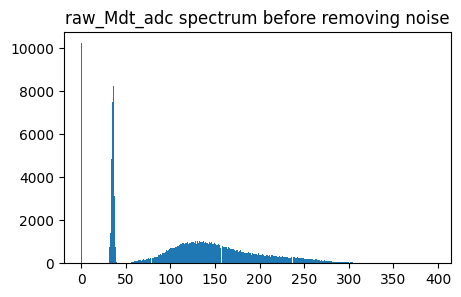

In [18]:
#raw_Mdt_adc spectrum before removing noise
fig,ax=plt.subplots(figsize=(5,3))
plt.hist(df_raw_chamber.rawMdt_adc, bins=400)
ax.set_title('raw_Mdt_adc spectrum before removing noise')
fig.savefig('raw_Mdt_adc_spectrum_BIS7A16_before_removing_noise')
plt.show()

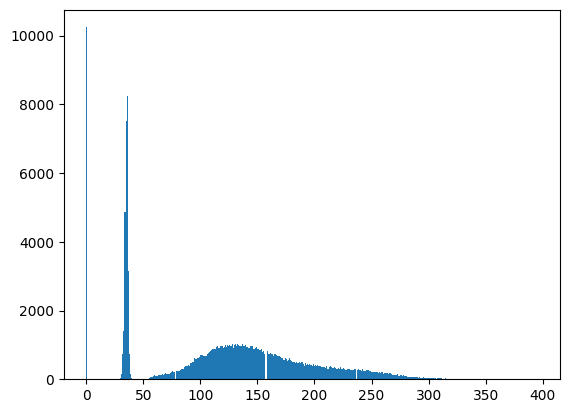

In [20]:
#raw_Mdt_adc spectrum after removing noise
plt.hist(df_raw_chamber.rawMdt_adc, bins=400)
ax.set_title('raw_Mdt_adc spectrum after removing noise')
fig.savefig('raw_Mdt_adc_spectrum_BIS7A16_after_removing_noise')
plt.show()

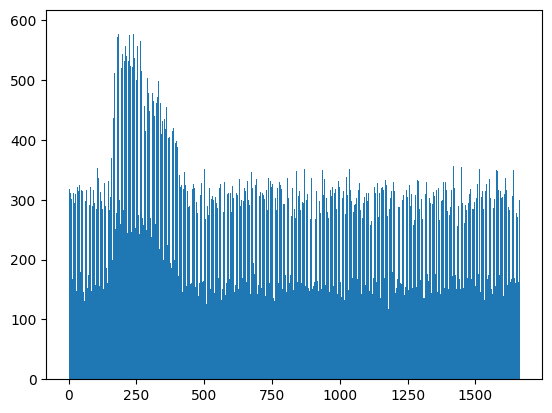

In [183]:
# rawMdt tdc spectrum  removing noise
plt.hist(df_raw_chamber.rawMdt_tdc, bins=1000)
plt.show()

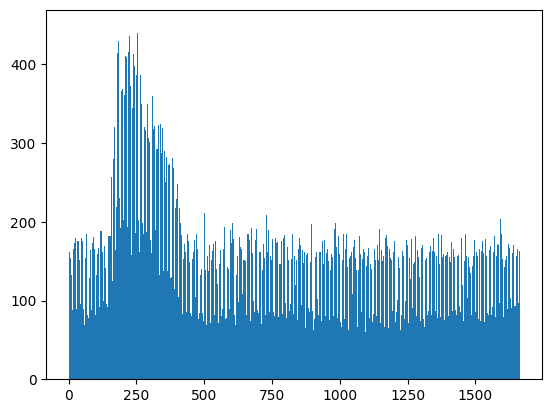

In [93]:
#rawMdt tdc spectrum after removing noise
plt.hist(df_raw_chamber.rawMdt_tdc, bins=1000)
plt.show()

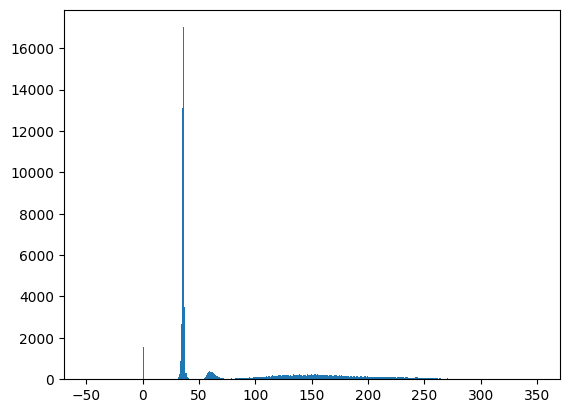

In [29]:
#adc spectrum
plt.hist(pd_mdt_chamber.rawMdt_adc, bins=400,range=(-50,350))
plt.show()

In [41]:
#plotting function for channel hitMap
def plothitMap(df_all, chamber):
    pd_mdt_chamber=df_all[df_all['rawMdt_station']==chamber]
    
    chamberinfo=list(pd_mdt_chamber.rawMdt_tubeinfo)
    ml=[int(x.split('_')[1]) for x in chamberinfo]
    ly=[int(x.split('_')[2]) for x in chamberinfo]
    nLayer=[(int(x.split('_')[1])-1)*4 + int(x.split('_')[2] for x in chamber)]

In [42]:
pd_mdt_chamber=df_raw[df_raw['rawMdt_station']=='BMG4A12']
chamberinfo=list(pd_mdt_chamber.rawMdt_tubeInfo)

len(chamberinfo)

chamberinfo #chamber, multi-layer, layer, tube
# BIS7A02/04/06/08/10/12/14/16
# Raw hit and TrkHit for BIS7A chambers to plot DriftTime and ADC
# both the raw hits and trk for all chambers
# report: slides, BIS... info about the noisy tubes
# 

['BMG4A12-1-4-41',
 'BMG4A12-1-4-1',
 'BMG4A12-1-3-42',
 'BMG4A12-1-3-40',
 'BMG4A12-1-2-43',
 'BMG4A12-1-1-43',
 'BMG4A12-1-1-22',
 'BMG4A12-1-1-22',
 'BMG4A12-1-1-1',
 'BMG4A12-1-4-37',
 'BMG4A12-1-4-24',
 'BMG4A12-1-3-54',
 'BMG4A12-1-1-54',
 'BMG4A12-1-1-22',
 'BMG4A12-2-4-42',
 'BMG4A12-2-3-42',
 'BMG4A12-2-3-20',
 'BMG4A12-2-2-42',
 'BMG4A12-2-1-41',
 'BMG4A12-1-3-54',
 'BMG4A12-1-2-32',
 'BMG4A12-1-1-7',
 'BMG4A12-1-4-24',
 'BMG4A12-1-4-1',
 'BMG4A12-1-3-54',
 'BMG4A12-1-1-22',
 'BMG4A12-1-4-1',
 'BMG4A12-1-3-54',
 'BMG4A12-1-2-7',
 'BMG4A12-1-2-1',
 'BMG4A12-1-1-22',
 'BMG4A12-1-1-1',
 'BMG4A12-1-3-23',
 'BMG4A12-1-2-1',
 'BMG4A12-1-1-54',
 'BMG4A12-1-1-1',
 'BMG4A12-1-1-1',
 'BMG4A12-1-4-15',
 'BMG4A12-1-3-54',
 'BMG4A12-2-4-54',
 'BMG4A12-2-4-53',
 'BMG4A12-2-4-52',
 'BMG4A12-2-4-51',
 'BMG4A12-2-4-49',
 'BMG4A12-2-3-54',
 'BMG4A12-2-3-53',
 'BMG4A12-2-3-52',
 'BMG4A12-2-3-51',
 'BMG4A12-2-3-50',
 'BMG4A12-2-3-48',
 'BMG4A12-2-2-51',
 'BMG4A12-2-2-50',
 'BMG4A12-2-2-49',
 'BM

In [43]:
#apply to ML-layer tube columns.  ????
ml=[int(x.split('-')[1]) for x in chamberinfo]

ly=[int(x.split('-')[2]) for x in chamberinfo]


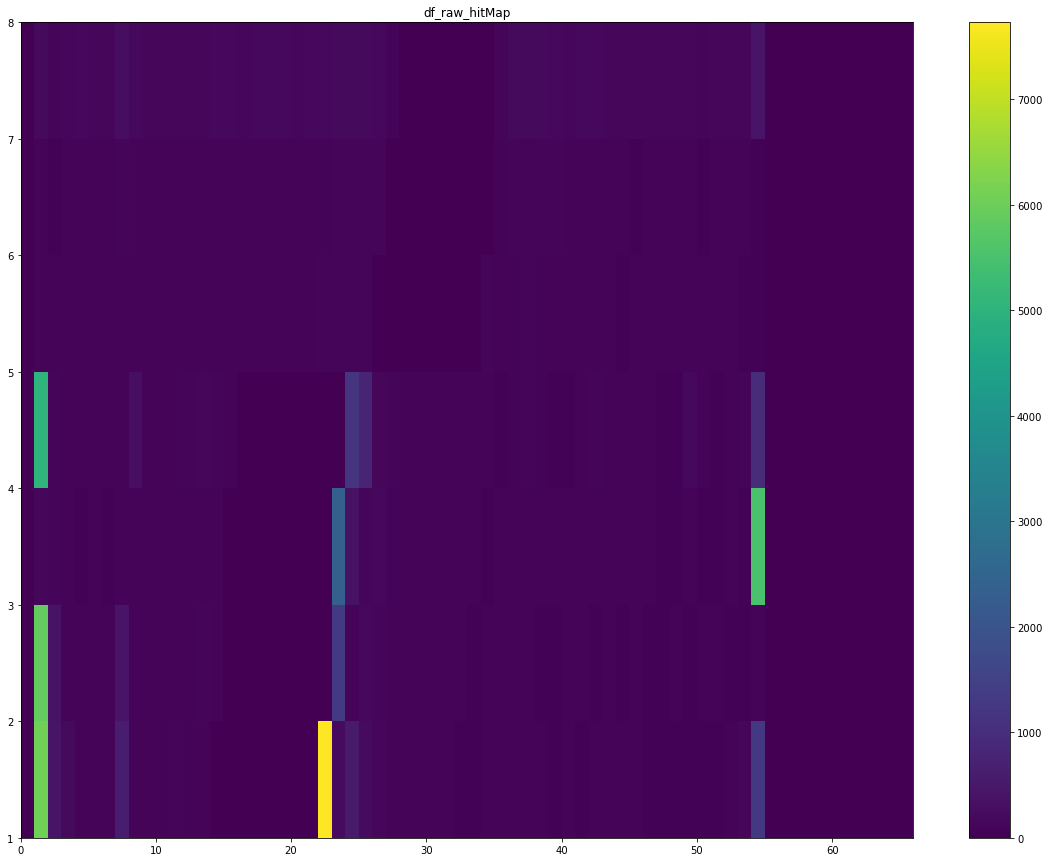

TypeError: savefig() missing 1 required positional argument: 'fname'

In [48]:
nLayer=[(int(x.split('-')[1])-1)*4 + int(x.split('-')[2]) for x in chamberinfo]                                   
tb=[int(x.split('-')[3]) for x in chamberinfo]

fig,ax=plt.subplots(figsize=(20,15))
ax.set_title('df_raw_hitMap')

# get Maxtube per layer and total layer from chamberlist_run3.py
maxLy = chamberlist_run3.MDTtotalLayers('BMG4A12')
maxTb = chamberlist_run3.MDTtotalTubes('BMG4A12')

#plot hitogram
counts,xedges,yedges,im=ax.hist2d(tb,nLayer,bins=[66,7],range=[[0,66],[1,8]],cmap=plt.cm.viridis,label='hitMap')
fig.colorbar(im, ax=ax)
plt.show()
fig.savefig()


In [50]:
xedges # (22,1)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66.])

In [51]:
yedges

array([1., 2., 3., 4., 5., 6., 7., 8.])

In [53]:
type(counts)

numpy.ndarray

In [55]:
counts[22][0]

7730.0

In [59]:
counts[1][0]

6064.0